In [1]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
x_train.shape

(60000, 28, 28)

In [3]:
x_train_shaped = (x_train.reshape(60000, 784).astype(float) - 127.5) / 127.5

## 創造一下 鑑賞家

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
discriminator = Sequential()
discriminator.add(Dense(units = 512, input_dim = 784, activation = "relu", kernel_initializer="random_normal"))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(units = 256, activation = 'relu', kernel_initializer = 'random_normal'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(units = 128, activation = 'relu', kernel_initializer = 'random_normal'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total para

## 創造一下 偽作者

In [5]:
random_dim = 100
generator = Sequential()
generator.add(Dense(units = 256, input_dim = 100, activation = "relu", kernel_initializer="random_normal"))
generator.add(Dropout(0.25))
generator.add(Dense(units = 512, activation = 'relu', kernel_initializer = 'random_normal'))
generator.add(Dropout(0.25))
# tanh-> -1~1
generator.add(Dense(units = 784, activation = 'tanh', kernel_initializer = 'random_normal'))

generator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 784)               402192    
Total params: 559,632
Trainable params: 559,632
Non-trainable params: 0
_________________________________________________________________


## 合併 -> 把真實秀給偽作者

In [6]:
from keras.models import Model
from keras.layers import Input
discriminator.trainable = False
gan_input = Input(shape=(random_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs = gan_input, outputs = gan_output)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 784)               559632    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 566273    
Total params: 1,125,905
Trainable params: 559,632
Non-trainable params: 566,273
_________________________________________________________________


In [33]:
import numpy as np
epochs = 10
batch = 200
for e in range(0, epochs):
    for b in range(0, 300):
        # Step0. 100 fake
        noise = np.random.normal(0, 1, (batch, random_dim))
        genimg = generator.predict(noise)

        # Step1. Train Discriminator
        idx = np.random.randint(0, 60000, batch)
        img = x_train_shaped[idx]
        discriminator.trainable = True
        valid = np.ones( (batch, 1) )

        fake = np.zeros( (batch, 1) )
        valid_loss = discriminator.train_on_batch(img, valid)
        fake_loss = discriminator.train_on_batch(genimg, fake)
        d_loss = (valid_loss + fake_loss) / 2
        # Step2. Train Generator
        noise = np.random.normal(0, 1, (batch, random_dim))
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, valid)
    print("Epoch", e)
    print("Discriminator Loss", d_loss)
    print("Generator Loss", g_loss)


Epoch 0
Discriminator Loss 0.5370586514472961
Generator Loss 1.2532203
Epoch 1
Discriminator Loss 0.5102740526199341
Generator Loss 1.5060271
Epoch 2
Discriminator Loss 0.4906493127346039
Generator Loss 1.3014059
Epoch 3
Discriminator Loss 0.5685809850692749
Generator Loss 1.0712842
Epoch 4
Discriminator Loss 0.5498601198196411
Generator Loss 1.5174344
Epoch 5
Discriminator Loss 0.5602489709854126
Generator Loss 1.2906756
Epoch 6
Discriminator Loss 0.5370701551437378
Generator Loss 1.3492837
Epoch 7
Discriminator Loss 0.5636795163154602
Generator Loss 1.1610724
Epoch 8
Discriminator Loss 0.5234990119934082
Generator Loss 1.2226907
Epoch 9
Discriminator Loss 0.518490195274353
Generator Loss 1.3417716


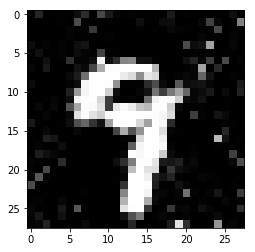

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
noise = np.random.normal(0, 1, (5, random_dim))
genimg = generator.predict(noise)
# -1~1 -> 0~1
gen_img = 0.5 * genimg + 0.5 
gen_img = gen_img.reshape(5, 28, 28)
plt.imshow(gen_img[0], cmap='gray')